<a href="https://colab.research.google.com/github/hanismors/portfolio/blob/main/hanis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders


In [34]:
!pip install --upgrade tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Using gpu**

In [5]:
# checking gpu support
gpus=tf.config.experimental.list_physical_devices()
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpus in gpus:
  tf.config.experimental.set_memory_growth(gpus, True)

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate

In [8]:
# import splitfolders
import os
import numpy as np
import pandas as pd
import random

In [9]:
# defining constants
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 50

In [10]:
# project's main directory
prj_dir = '/content/drive/My Drive/dataset'

In [11]:
# building tf input data pipeline
ds = tf.keras.utils.image_dataset_from_directory(
    f'{prj_dir}/data',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 7387 files belonging to 3 classes.


In [12]:
# getting class names
class_names = ds.class_names
class_names

['Bacterial_spot', 'Leaf_Mold', 'Spider_mites Two-spotted_spider_mite']

Batch 1 Imgs shape: (32, 256, 256, 3)
Batch 1 Lbls: [0 0 0 1 0 0 1 1 2 1 1 2 2 2 0 0 1 1 0 2 1 1 1 0 1 0 2 0 0 2 1 0]


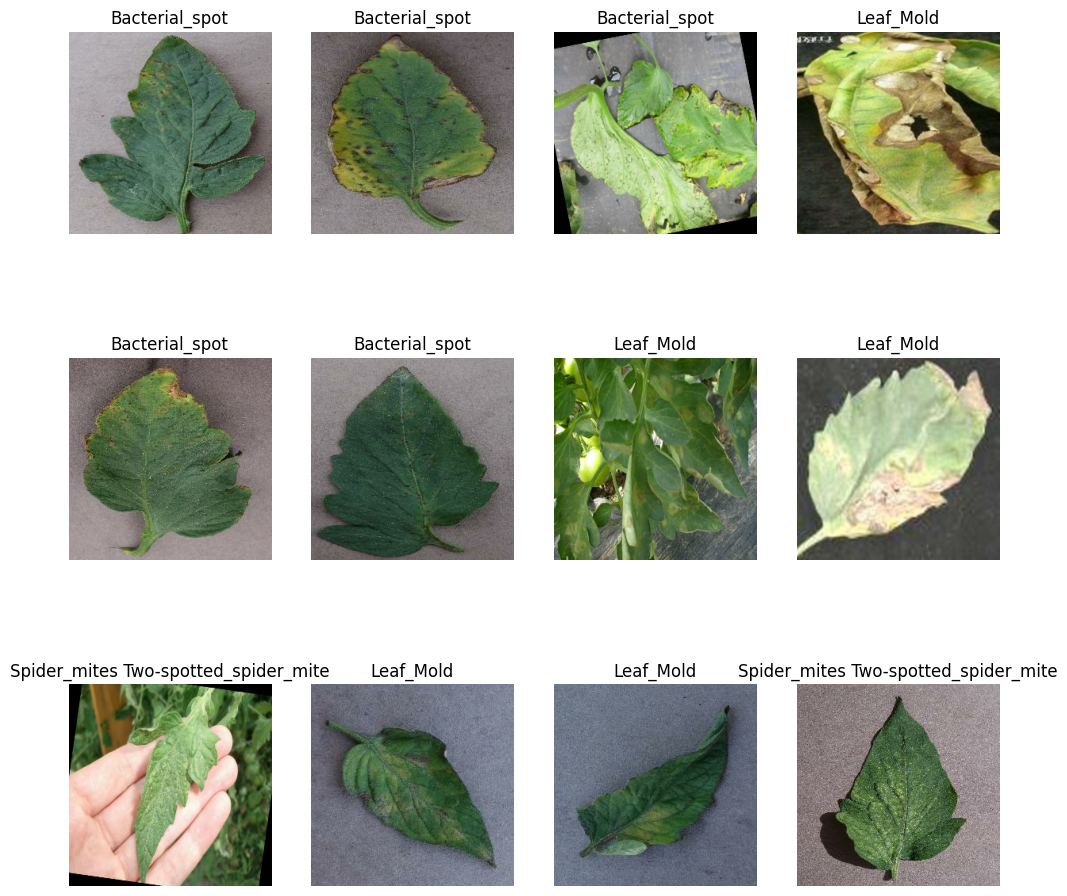

In [13]:
# displaying sample data
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in ds.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image

    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

In [14]:
# creating training set, validation set and testing set
ds_size = len(ds)

ds = ds.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 231
Train set size : 166
Val set size   : 41
Test set size  : 24


In [15]:
# optimizing tf input data pipeline performance

# caching for epochs
# prefetching tf-determined data into CPU as GPU computes - AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size).skip(val_size)

In [17]:
len(train)

166

In [18]:
# resizing and rescaling layers
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),  # during prediction
    tf.keras.layers.Rescaling(1.0 / 255)  # rescaling rgb values to between 0.0 and 1.0
])

In [19]:
# data augmentation to make model robust and prevent overfitting
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])

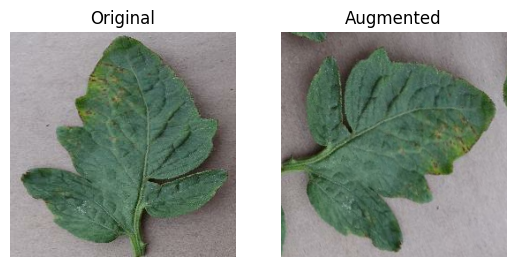

In [20]:
# testing data augmentation
imgs = [img, data_aug(img).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

**Build deep learning model**

In [21]:
# building model with alternating Conv2D and MaxPooling2D layers
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3) # 3 channels - rgb
n_classes = len(class_names)

model = models.Sequential([
    resize_rescale, # layers.InputLayer(input_shape=input_shape) # using data generator
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=n_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.build(input_shape=input_shape)

In [23]:
model.summary() # all trainable parameters -> no transfer learning

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# compiling model with optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
train_dir = f'{prj_dir}/Training' # training directory

In [26]:
train_ver = len(os.listdir(train_dir)) # latest saved training
print(f'Latest saved training ver: {train_ver}')

Latest saved training ver: 0


In [27]:
cps_dir = '/content/drive/My Drive/dataset/training-1/cp-{epoch:04d}.weights.h5'
# Create the directory if it does not exist
os.makedirs(os.path.dirname(cps_dir), exist_ok=True)

In [28]:
# callback to save model's weights at every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cps_dir,
    verbose=1,
    save_weights_only=True
)

In [29]:
model.save_weights(cps_dir.format(epoch=0))

In [30]:
logdir='logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir,
)

In [ ]:
# fitting model
history = model.fit( # using data generator
    train_set, # train_data_gen
    epochs=10, # , steps_per_epoch=train_imgs / BATCH_SIZE
    batch_size=16,
    callbacks=[tensorboard_callback],
    validation_data=val_set, # validation_data=val_data_gen, validation_steps=val_imgs / BATCH_SIZE
    verbose=1
)

Epoch 1/10
